<a href="https://colab.research.google.com/github/bhaveshasasik/nfl_game_predictor/blob/main/Random_forest_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accuracy: 0.7027027027027027
Precision: 0.6868686868686869
Recall: 0.7391304347826086
F1 Score: 0.7120418848167539
ROC AUC Score: 0.7899135109864422

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.67      0.69        93
           1       0.69      0.74      0.71        92

    accuracy                           0.70       185
   macro avg       0.70      0.70      0.70       185
weighted avg       0.70      0.70      0.70       185



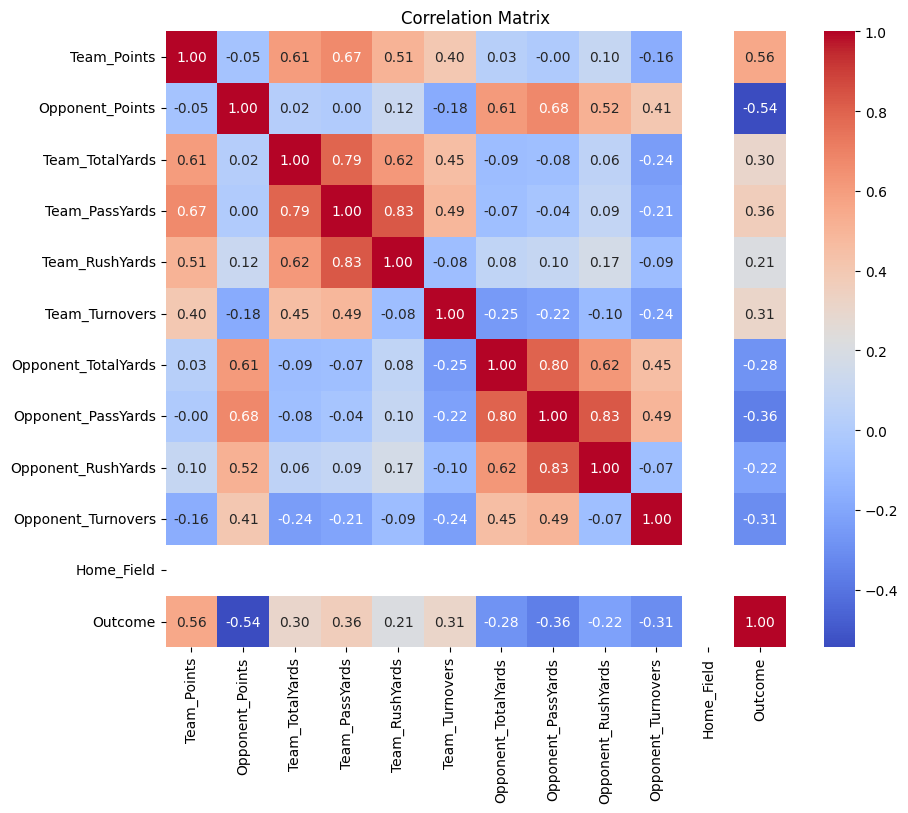

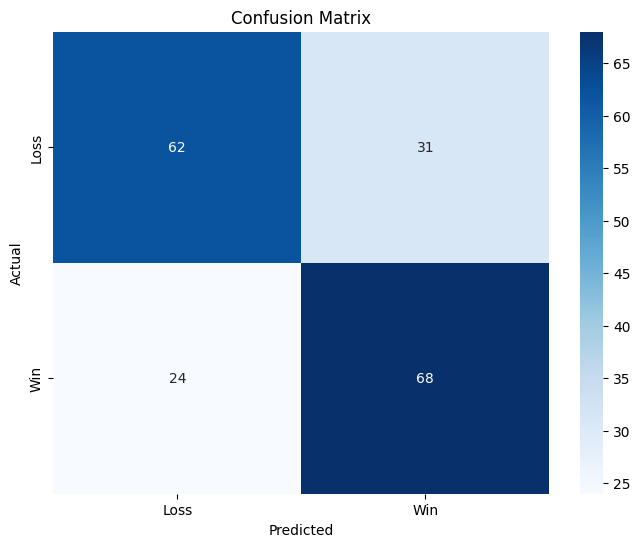

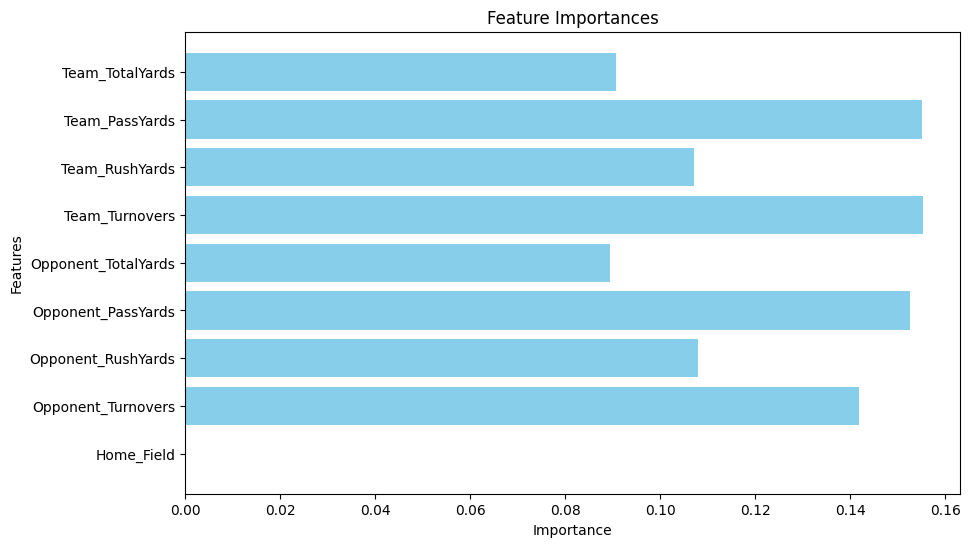

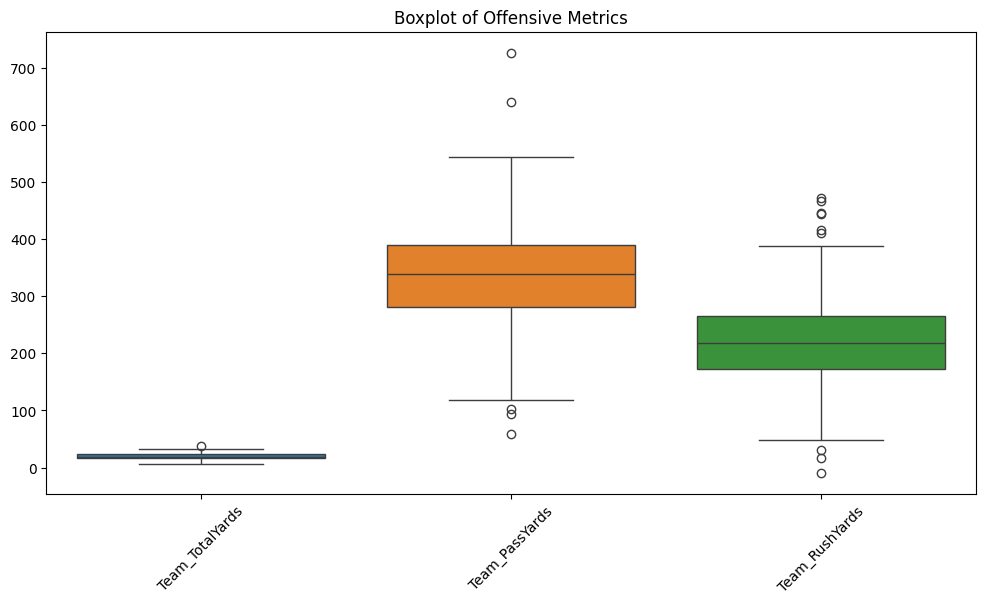

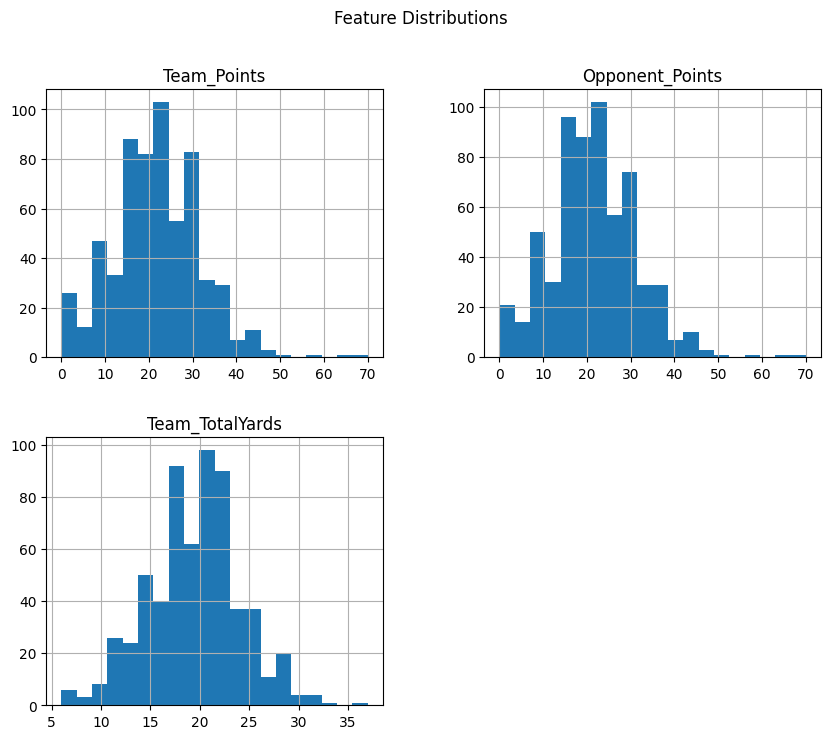


Grouped Statistics by Home_Field:
             Team_Points  Opponent_Points
Home_Field                              
0             21.931596        21.830619
Predicted Winner: steelers
Confidence: 0.41


('steelers', 0.41)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocess Function
def preprocess_all_files(file_paths):
    all_data = []
    for file_path in file_paths:
        data = pd.read_csv(file_path)
        if 'Unnamed: 0' in data.columns:
            data = data[data['Unnamed: 0'] != 'Week']
            data['Home_Field'] = (data['Unnamed: 0'] == 'Home').astype(int)
        else:
            data['Home_Field'] = 0  # Default to 0 if column is missing

        data.rename(columns={
            'Score': 'Team_Points',
            'Score.1': 'Opponent_Points',
            'Offense': 'Team_TotalYards',
            'Offense.1': 'Team_PassYards',
            'Offense.2': 'Team_RushYards',
            'Offense.3': 'Team_Turnovers',
            'Defense': 'Opponent_TotalYards',
            'Defense.1': 'Opponent_PassYards',
            'Defense.2': 'Opponent_RushYards',
            'Defense.3': 'Opponent_Turnovers'
        }, inplace=True)
        numeric_cols = [
            'Team_Points', 'Opponent_Points', 'Team_TotalYards', 'Team_PassYards',
            'Team_RushYards', 'Team_Turnovers', 'Opponent_TotalYards',
            'Opponent_PassYards', 'Opponent_RushYards', 'Opponent_Turnovers'
        ]

        # Drop irrelevant columns (e.g., unnamed columns)
        data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

        # Replace non-numeric values with NaN and drop them
        for col in numeric_cols:
            data[col] = pd.to_numeric(data[col], errors='coerce')

        # Handle missing data for important columns
        data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

        # Add team information
        data['Team'] = file_path.split('/')[-1].split('_')[0]

        all_data.append(data)

    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data

# Train and Evaluate Function with EDA and Visualizations
def train_and_evaluate_model_with_visuals(combined_data):
    features = ['Team_TotalYards', 'Team_PassYards', 'Team_RushYards', 'Team_Turnovers',
                'Opponent_TotalYards', 'Opponent_PassYards', 'Opponent_RushYards', 'Opponent_Turnovers', 'Home_Field']
    combined_data['Outcome'] = (combined_data['Team_Points'] > combined_data['Opponent_Points']).astype(int)
    X = combined_data[features]
    y = combined_data['Outcome']

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Print metrics
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    numeric_data = combined_data.select_dtypes(include=np.number)
    correlation_matrix = numeric_data.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()

    # Confusion matrix visualization
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Loss", "Win"], yticklabels=["Loss", "Win"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Feature importance visualization
    feature_importances = model.feature_importances_
    feature_names = features
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_importances, color='skyblue')
    plt.title("Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.gca().invert_yaxis()
    plt.show()

    # Outlier Analysis
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=combined_data[['Team_TotalYards', 'Team_PassYards', 'Team_RushYards']])
    plt.title("Boxplot of Offensive Metrics")
    plt.xticks(rotation=45)
    plt.show()

    # Feature Distributions
    combined_data[['Team_Points', 'Opponent_Points', 'Team_TotalYards']].hist(figsize=(10, 8), bins=20)
    plt.suptitle("Feature Distributions")
    plt.show()

    # Grouped Statistics by Home-Field Advantage
    home_field_stats = combined_data.groupby('Home_Field').mean(numeric_only=True)[['Team_Points', 'Opponent_Points']]
    print("\nGrouped Statistics by Home_Field:\n", home_field_stats)

    return model, combined_data, scaler

# Predict Matchup
def predict_matchup(model, combined_data, scaler, team_a, team_b, home_team):
    team_a_stats = combined_data[combined_data['Team'] == team_a].iloc[0][
        ['Team_TotalYards', 'Team_PassYards', 'Team_RushYards', 'Team_Turnovers']
    ].tolist()
    team_b_stats = combined_data[combined_data['Team'] == team_b].iloc[0][
        ['Team_TotalYards', 'Team_PassYards', 'Team_RushYards', 'Team_Turnovers']
    ].tolist()
    home_field = 1 if home_team == team_a else 0

    matchup_stats = pd.DataFrame([team_a_stats + team_b_stats + [home_field]], columns=[
        'Team_TotalYards', 'Team_PassYards', 'Team_RushYards', 'Team_Turnovers',
        'Opponent_TotalYards', 'Opponent_PassYards', 'Opponent_RushYards', 'Opponent_Turnovers', 'Home_Field'
    ])
    matchup_stats = scaler.transform(matchup_stats)
    prediction = model.predict(matchup_stats)
    probability = model.predict_proba(matchup_stats)[0][1]
    outcome = team_a if prediction[0] == 1 else team_b
    print(f"Predicted Winner: {outcome}")
    print(f"Confidence: {probability:.2f}")
    return outcome, probability

# File paths for the data
file_paths = [
    '../bears_data.csv',
    '../bengals_data.csv',
    '../bills_data.csv',
    '../broncos_data.csv',
    '../browns_data.csv',
    '../buccaneers_data.csv',
    '../cardinals_data.csv',
    '../chargers_data.csv',
    '../chiefs_data.csv',
    '../colts_data.csv',
    '../commanders_data.csv',
    '../cowboys_data.csv',
    '../dolphins_data.csv',
    '../eagles_data.csv',
    '../falcons_data.csv',
    '../giants_data.csv',
    '../jaguars_data.csv',
    '../jets_data.csv',
    '../lions_data.csv',
    '../packers_data.csv',
    '../panthers_data.csv',
    '../patriots_data.csv',
    '../raiders_data.csv',
    '../rams_data.csv',
    '../ravens_data.csv',
    '../saints_data.csv',
    '../seahawks_data.csv',
    '../steelers_data.csv',
    '../texans_data.csv',
    '../titans_data.csv',
    '../vikings_data.csv',
    '../49ers_data.csv'
]

# Preprocess and train the model
combined_data = preprocess_all_files(file_paths)
model, combined_data, scaler = train_and_evaluate_model_with_visuals(combined_data)

# Predict a matchup
team_a = "texans"
team_b = "steelers"
home_team = "texans"  # Specify which team has home-field advantage
predict_matchup(model, combined_data, scaler, team_a, team_b, home_team)